Imports

In [27]:
from nes_py.wrappers import JoypadSpace
import gym
import torch
from gymUtils import RamWrapper
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, RIGHT_ONLY 

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback

import time
import os
from typing import Callable, List, Dict, Any, Union, Optional
import matplotlib.pyplot as plt

In [20]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v1')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

Process Environment

In [21]:
# Setup cropping size
x0 = 0
x1 = 16
y0 = 0
y1 = 13
n_stack = 4
n_skip = 4

env_wrap = RamWrapper(env, [x0, x1, y0, y1], n_stack=n_stack, n_skip=n_skip)

In [22]:
# test env_wrap
done = True
for i in range(150):
    if done:
        state = env_wrap.reset()
    state, reward, done, info = env_wrap.step(env_wrap.action_space.sample())

C:\Windows\Temp\ipykernel_19608\2465258508.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


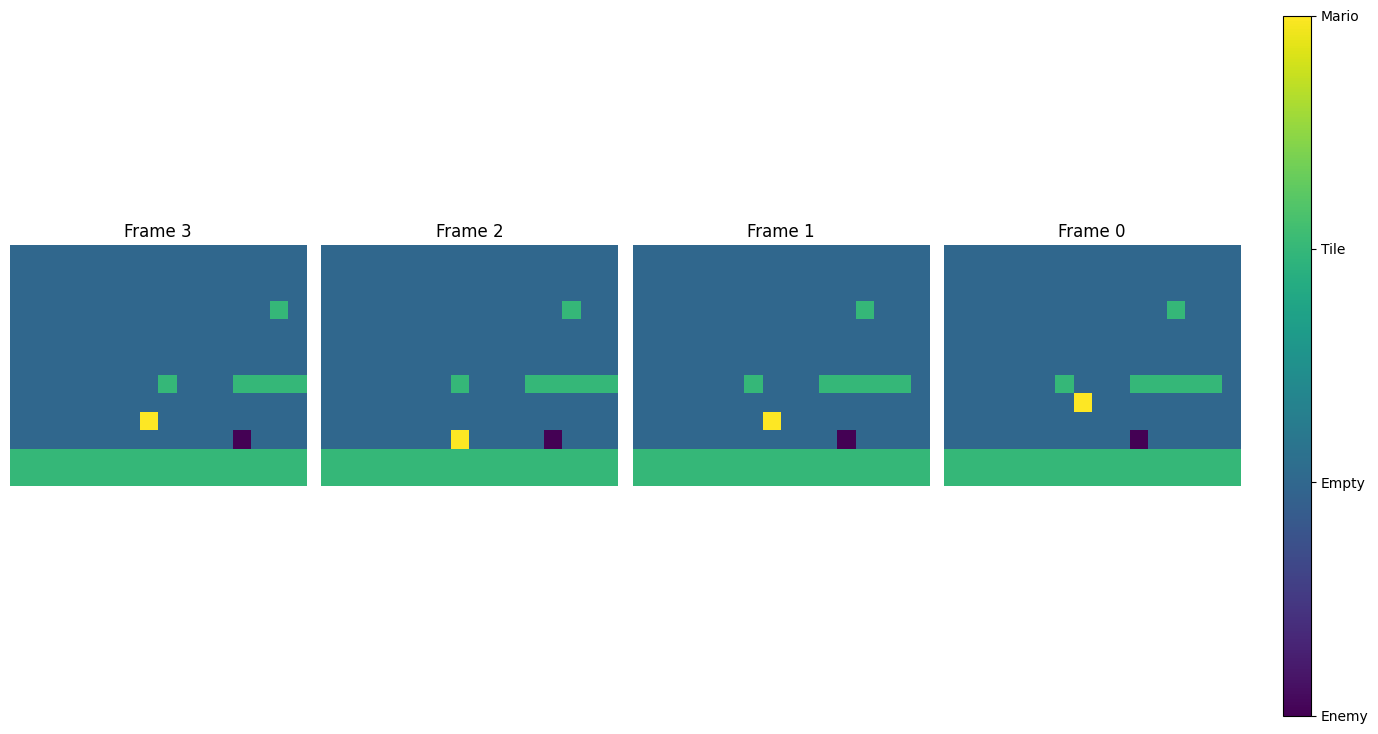

In [23]:
fig, ax = plt.subplots(1, n_stack, figsize=(14, 10))
for i in range(n_stack):
    # Display frames from newest to oldest
    ax[i].imshow(state[:, :, n_stack-i-1], vmin=-1, vmax=2, cmap='viridis')
    ax[i].set_title(f'Frame {n_stack-i-1}')
    ax[i].axis('off')

# Create a colorbar legend
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(ax[0].images[0], cax=cbar_ax)
cbar.set_ticks([-1, 0, 1, 2])
cbar.set_ticklabels(['Enemy', 'Empty', 'Tile', 'Mario'])

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [24]:
# Apply other wrapper functions
env_wrap = Monitor(env_wrap)
env_wrap = DummyVecEnv([lambda: env_wrap])

Setup RL Model

In [28]:
class ModelCheckpointCallback(BaseCallback):
    """
    Callback for saving model checkpoints during training at specified intervals.
    
    This callback saves the model periodically based on the number of training steps.
    """
    
    def __init__(self, 
                 check_freq: int, 
                 save_path: str, 
                 starting_steps: int = 0, 
                 verbose: int = 1):
        """
        Initialize the checkpoint callback.
        
        Args:
            check_freq (int): How often to save the model (in steps)
            save_path (str): Directory path to save model checkpoints
            starting_steps (int): Starting step count if resuming training
            verbose (int): Verbosity level (0: no output, 1: info)
        """
        super(ModelCheckpointCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.starting_steps = starting_steps
    
    def _init_callback(self):
        """Create the checkpoint directory if it doesn't exist."""
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
    
    def _on_step(self):
        """
        Save the model when the specified number of steps has been reached.
        
        Returns:
            bool: Whether training should continue (always True)
        """
        if self.n_calls % self.check_freq == 0:
            total_steps = self.n_calls + self.starting_steps
            checkpoint_path = os.path.join(
                self.save_path, 
                f'model_checkpoint_{total_steps}'
            )
            self.model.save(checkpoint_path)
            if self.verbose > 0:
                print(f"Saved model checkpoint at {total_steps} steps")
        
        return True


def linear_learning_rate_schedule(initial_lr: float) -> Callable[[float], float]:
    """
    Creates a linear learning rate decay schedule.
    
    The learning rate decreases linearly from the initial value to zero
    as training progresses from start to finish.
    
    Args:
        initial_lr (float): The starting learning rate
        
    Returns:
        callable: A function that computes the current learning rate
                 based on remaining progress
    """
    def scheduler(progress_remaining: float) -> float:
        """
        Calculate current learning rate based on remaining progress.
        
        Args:
            progress_remaining (float): Value from 1.0 (training start) 
                                      to 0.0 (training end)
        
        Returns:
            float: Current learning rate
        """
        return progress_remaining * initial_lr
    
    return scheduler


In [29]:
MODEL = './models/v3'
LOG = './logs/v3'
model = PPO('MlpPolicy', env_wrap, verbose=1, learning_rate=linear_learning_rate_schedule(3e-4), tensorboard_log=LOG)

Using cpu device


In [30]:
callback = ModelCheckpointCallback(check_freq=1e5, starting_steps=0, save_path=MODEL)

Train Model

In [ ]:
t_start = time.time()

model.learn(total_timesteps=10e6, callback=callback)

t_elapsed = time.time() - t_start

Logging to ./logs/v3\PPO_2


f:\MarioML\venv\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


-----------------------------
| time/              |      |
|    fps             | 363  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 387          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0061184163 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | -0.0188      |
|    learning_rate        | 0.0003       |
|    loss                 | 32.6         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00704     |
|    value_loss           | 116          |
------------------------------------------
----------------

Save and load trained model

In [ ]:
# Save model
model_path = os.path.join(MODEL, 'marioV1')
model.save(model_path)

NameError: name 'MODEL' is not defined

In [ ]:
del model

In [31]:
# Load model
MODEL = './marioV1'
LOG = './'

model_path = MODEL
model = PPO.load(model_path, env=env_wrap)

Test Our Model

In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

evaluate_policy(model, env_wrap, n_eval_episodes=1, deterministic=True, render=False, return_episode_rewards=False)

episode = 1

for episode in range(1, episode+1):
    states = env_wrap.reset()
    done = False
    score = 0
    
    while not done:
        env_wrap.render()
        action, _ = model.predict(states, deterministic=True)
        states, reward, done, info = env_wrap.step(action)
        score += reward
        time.sleep(0.01)
    print('Episode:{} Score:{}'.format(episode, score))
env.close()

Episode:1 Score:[3066.]
